In [67]:
import pandas as pd 
import numpy as np 


import os, re, random, warnings



# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

from sklearn.cluster import KMeans # , AgglomerativeClustering, DBSCAN

from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score

import datetime

import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as go

from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


# from io import BytesIO
# from io import StringIO



import  random
from pylab import *


from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt



# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10,7)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline 

warnings.filterwarnings("ignore")

https://www.kaggle.com/datasets/ilkeryildiz/online-retail-listing

In [76]:
df = pd.read_csv('online_retail_listing.csv', sep = ';',encoding='latin1')

In [77]:
df_initial=df.copy()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  object 
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 64.0+ MB


In [79]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,"6,95",13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,"2,1",13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,"1,25",13085.00,United Kingdom


In [80]:
# date time 
df.InvoiceDate = pd.to_datetime(df['InvoiceDate'])

# price preparetion 
df.Price = df.apply(lambda row: row['Price'].replace(",", "."), axis = 1)
df.Price= df.Price.astype('float')

df.rename(columns = {'Customer ID':'Customer_ID'}, inplace = True)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1048575 non-null  object        
 1   StockCode    1048575 non-null  object        
 2   Description  1044203 non-null  object        
 3   Quantity     1048575 non-null  int64         
 4   InvoiceDate  1048575 non-null  datetime64[ns]
 5   Price        1048575 non-null  float64       
 6   Customer_ID  811893 non-null   float64       
 7   Country      1048575 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 64.0+ MB


In [74]:
df = df[df.Quantity > 0]
df = df[df.Price > 0] 

In [52]:
max_date = df['InvoiceDate'].max()
NOW = max_date + datetime.timedelta(days=1)

In [86]:
df.Customer_ID.nunique()

5924

In [87]:
def RFM_calculator(rfm_df, date_column:str, monetary_column:str):

    max_date = rfm_df[date_column].max()
    NOW = max_date + datetime.timedelta(days=1)

    rfm_table = df.groupby(['Customer_ID']).agg({'InvoiceDate': lambda x: (NOW - x.max()).days,
                                                               'Invoice': lambda x: x.nunique(),
                                                               'Price': lambda x: x.sum()}).reset_index()

    rfm_table['InvoiceDate'] = rfm_table['InvoiceDate'].astype(int)

    rfm_table.rename(columns={'InvoiceDate': 'recency', 
                             'Invoice': 'frequency', 
                             'Price': 'monetary_value'}, inplace=True)
    return rfm_table




In [88]:
rfm_table = RFM_calculator(df,  'InvoiceDate', 'Price')

In [89]:
rfm_table

,Customer_ID,recency,frequency,monetary_value
0,12346.00,327,17,580.44
1,12347.00,41,7,630.62
2,12348.00,77,5,193.10
3,12349.00,20,5,1504.59
4,12350.00,312,1,65.30
...,...,...,...,...
5919,18283.00,11,21,1654.37
5920,18284.00,549,2,116.09
5921,18285.00,662,1,100.20
5922,18286.00,478,3,306.55


In [91]:
X = rfm_table[['recency', 'frequency', 'monetary_value']].copy()


In [92]:
scaler_ss = StandardScaler()

scaler_ss.fit(X)
X_ss = scaler_ss.transform(X)



In [93]:

def ClusteringParams(X):
    range_n_clusters = range(3,25)
    eval_scores = {'model':[],'n_clusters':[], 's_score':[]}#, 'c_score':[], 'db_score':[]}

    for n_clusters in range_n_clusters:

        Kmeans_clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
        eval_scores['model'].append('KMeans')

        cluster_labels = Kmeans_clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels, random_state = 42)

        eval_scores['n_clusters'].append(n_clusters)
        eval_scores['s_score'].append(silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

    eval_scores = pd.DataFrame(eval_scores)
#     fig.savefig('silhouette.png')
    return eval_scores




In [94]:
kmeans_params= ClusteringParams(X_ss)
kmeans_params

,model,n_clusters,s_score
0,KMeans,3,0.56
1,KMeans,4,0.59
2,KMeans,5,0.59
3,KMeans,6,0.57
4,KMeans,7,0.52
5,KMeans,8,0.50
6,KMeans,9,0.49
7,KMeans,10,0.46
8,KMeans,11,0.46
9,KMeans,12,0.45


In [95]:
def elbow(x):
    wcss=[]

    for i in range(1,10):
        kmeans = KMeans(i)
        kmeans.fit(x)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,10)
    plt.plot(number_clusters,wcss)
    plt.title('The Elbow title')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    
    
def kmeans_clustering(x, df, n_cluster):

    kmeans = KMeans(n_clusters= n_cluster, random_state=42, init='k-means++', max_iter=100, n_init=1, verbose=0)
    kmeans.fit(x)
    
    df['clusters'] = kmeans.predict(x) + 1
    
    
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return df, centers, labels


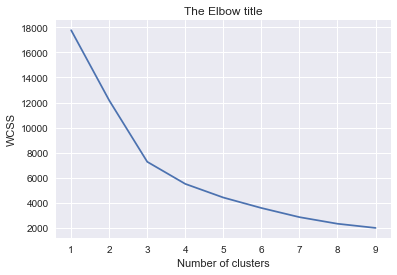

In [96]:
elbow(X_ss)

In [97]:
kmeans = KMeans(n_clusters= 4, random_state=42, init='k-means++', max_iter=40, n_init=1, verbose=0)
kmeans.fit(X_ss)

KMeans(max_iter=40, n_clusters=4, n_init=1, random_state=42)

In [98]:
rfm_table['clusters'] = kmeans.predict(X_ss) + 1

In [99]:
rfm_table.groupby('clusters').count()

,Customer_ID,recency,frequency,monetary_value
clusters,,,,
1,3870,3870,3870,3870
2,2034,2034,2034,2034
3,1,1,1,1
4,19,19,19,19


In [100]:
rfm_table[['recency','frequency','monetary_value','clusters']].groupby('clusters').describe().transpose()

clusters                    1       2        3        4
recency        count  3870.00 2034.00     1.00    19.00
               mean     72.96  474.80     1.00   132.47
               std      69.63  144.04      NaN   231.09
               min       1.00  255.00     1.00     1.00
               25%      19.00  378.00     1.00     3.50
               50%      47.00  438.00     1.00    13.00
               75%     109.00  565.75     1.00    68.00
               max     422.00 1063.00     1.00   632.00
frequency      count  3870.00 2034.00     1.00    19.00
               mean      9.34    2.48   503.00   137.37
               std      12.46    2.53      NaN   114.52
               min       1.00    1.00   503.00     1.00
               25%       3.00    1.00   503.00    13.50
               50%       5.00    2.00   503.00   150.00
               75%      11.00    3.00   503.00   223.50
               max     161.00   35.00   503.00   360.00
monetary_value count  3870.00 2034.00     1.00    19.00
               mean    547.46  169.45 70424.29 24319.21
               std     846.41  393.63      NaN 10942.13
               min       0.00    0.00 70424.29  8961.81
               25%     102.81   35.87 70424.29 13963.46
               50%     261.52   84.51 70424.29 25111.09
               75%     645.11  174.16 70424.29 34461.24
               max   14573.16 9416.82 70424.29 40278.90

In [101]:
fig = px.scatter_3d(rfm_table, x = 'recency', 
                    y = 'frequency', z = 'monetary_value',
                    color = 'clusters')
  
fig.show()

In [ ]:

# Get the current working directory
cwd = os.getcwd()